### Import des Bibliothéques
---

In [5]:
import pandas as pd
import numpy as np
import pickle
import os
import boto3
import pickle # moyen le plus simple et direct pour sauvegarder et recharger un modèle Python entier.
import statsmodels.api as sm

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error



### Chargement fichier df_reduced.csv du S3 
---

In [8]:
load_dotenv("../secrets.env")

AWS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET = os.getenv("AWS_SECRET_ACCESS_KEY")
BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")

s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_KEY,
    aws_secret_access_key=AWS_SECRET
)

# chargement fichier du S3
s3.download_file(BUCKET_NAME, "df_reduced.csv", "df_reducedS3.csv")

# Lecture des fichiers 
df_reducedS3 = pd.read_csv("df_reducedS3.csv")

display(df_reducedS3.head())


,Département,année,densité,pop_globale,tranche_age_0-24,tranche_age_25-59,tranche_age_60+,csp1_agriculteurs,csp2_artisans_commerçant_chef_entreprises,csp3_cadres_professions_intellectuelles,...,nb_salaries_secteur_industrie,nb_salaries_secteur_service,nbre_entreprises_agricole,nbre_entreprises_industrie,nbre_entreprises_service,Total_autres_dechets,Déblais_gravats,Déchets_verts,Encombrants,Matériaux_recyclables
0,Ain,2009,101.8,588857,188068,281744,119045,4017,17226,37333,...,68343,141408,3092,6263,15605,4803,37593,45013,34729,25405
1,Aisne,2009,73.4,539547,170369,249910,119268,5250,11668,19234,...,44128,129961,3720,3913,11215,1180,24380,24539,31593,10542
2,Allier,2009,46.6,342559,86913,152570,103076,6019,9743,12045,...,31537,92422,3325,3011,8474,1867,14374,18612,11932,8564
3,Alpes-de-Haute-Provence,2009,23.0,159510,43500,70222,45788,2136,6704,7210,...,10803,44575,1473,2096,6415,803,11228,8280,9006,7327
4,Hautes-Alpes,2009,24.5,135883,37235,62716,35932,2214,5658,6070,...,8607,46547,1333,1869,5980,1048,8509,6121,7938,10344


In [3]:
print(df_reducedS3.columns)

Index(['Département', 'année', 'densité', 'pop_globale', 'tranche_age_0-24',
       'tranche_age_25-59', 'tranche_age_60+', 'csp1_agriculteurs',
       'csp2_artisans_commerçant_chef_entreprises',
       'csp3_cadres_professions_intellectuelles',
       'csp4_professions_intermédiaires', 'csp5_employés', 'csp6_ouvriers',
       'csp7_retraités', 'csp8_sans_activité', 'nbre_entreprises',
       'nb_salaries_secteur_agricole', 'nb_salaries_secteur_industrie',
       'nb_salaries_secteur_service', 'nbre_entreprises_agricole',
       'nbre_entreprises_industrie', 'nbre_entreprises_service',
       'Total_autres_dechets', 'Déblais_gravats', 'Déchets_verts',
       'Encombrants', 'Matériaux_recyclables'],
      dtype='object')


### Modéle OLS
---

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import pandas as pd
import numpy as np
import pickle


# Targets à prédire
targets = [
    'Total_autres_dechets',
    'Déblais_gravats',
    'Déchets_verts',
    'Encombrants',
    'Matériaux_recyclables'
]

#  Création dataFrame pour stocker les résultats 
df_results = pd.DataFrame(columns=['cible','R2_train','R2_test','MAE','RMSE'])

# Boucle sur chaque target 
for target in targets:
    print(f"--- Traitement de {target} ---")
    
    X = df_reducedS3.drop(columns=[target])
    y = df_reducedS3[target]
    
    # Diviser train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Identifier colonnes numériques et catégorielles
    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # ColumnTransformer pour standardiser et encoder 
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ])
    
    # Encoder train et test (converti en dense)
    X_train_enc = preprocessor.fit_transform(X_train)
    X_test_enc = preprocessor.transform(X_test)
    
    # Ajouter constante pour OLS
    X_train_enc_const = sm.add_constant(X_train_enc)
    X_test_enc_const = sm.add_constant(X_test_enc, has_constant='add')
    
    # Modèle 
    ols_model = sm.OLS(y_train, X_train_enc_const).fit()
    
    # Pipeline (inclut le préprocesseur et le modèle) pour sauvegarder aussi le preprocessor et le model (evite la dif du nbre de col)
    pipeline = {
        "preprocessor": preprocessor,
        "ols_model": ols_model
    }

    # Sauvegarde du pipeline
    with open(f"model_ols_{target}.pkl", "wb") as f:
        pickle.dump(pipeline, f)

    # Prédictions
    y_train_pred = ols_model.predict(X_train_enc_const)
    y_test_pred = ols_model.predict(X_test_enc_const)
    
    # Calcul des métriques
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = round(mean_absolute_percentage_error(y_test, y_test_pred),4) * 100  # en %
    
    # Stocker les résultats
    df_results = pd.concat([df_results, pd.DataFrame([{
        'cible': target,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape 
    }])], ignore_index=True)
    
df_results.head()

--- Traitement de Total_autres_dechets ---
--- Traitement de Déblais_gravats ---
--- Traitement de Déchets_verts ---
--- Traitement de Encombrants ---


C:\Users\natha\AppData\Local\Temp\ipykernel_472\308177057.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([{


--- Traitement de Matériaux_recyclables ---


,cible,R2_train,R2_test,MAE,RMSE,MAPE
0,Total_autres_dechets,0.852505,0.763521,2945.929513,4790.515765,49.37
1,Déblais_gravats,0.973181,0.974606,4248.225994,6408.328741,19.43
2,Déchets_verts,0.987394,0.933627,4522.437305,9102.058983,14.84
3,Encombrants,0.970889,0.901533,5023.831558,8634.605841,13.04
4,Matériaux_recyclables,0.982392,0.963132,2166.528217,2995.279314,13.58


### Analyse des coefficients sur la terget Matériaux recyclables par exemple
---

In [10]:
print(ols_model.summary())


                              OLS Regression Results                             
Dep. Variable:     Matériaux_recyclables   R-squared:                       0.982
Model:                               OLS   Adj. R-squared:                  0.977
Method:                    Least Squares   F-statistic:                     199.8
Date:                   Tue, 14 Oct 2025   Prob (F-statistic):          1.64e-309
Time:                           10:56:08   Log-Likelihood:                -4861.3
No. Observations:                    537   AIC:                             9959.
Df Residuals:                        419   BIC:                         1.046e+04
Df Model:                            117                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.225e+04 

In [ ]:
# Obtenir les noms des colonnes après encodage
feature_names = preprocessor.get_feature_names_out()

# Créer le DataFrame avec les bons noms
coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': ols_model.params[1:]  # [1:] pour ignorer la constante
}).sort_values(by='Coefficient', ascending=False)

# Après avoir construit le df `coefs` filtrer le département pour les retirer de l'analyse
coefs_filtered = coefs[~coefs['Variable'].str.contains('Département|Departement|dep_', case=False, regex=True)]

coefs_filtered.head(10)


,Variable,Coefficient
x11,num__csp5_employés,26075.865032
x9,num__csp3_cadres_professions_intellectuelles,13739.778685
x10,num__csp4_professions_intermédiaires,13629.990682
x2,num__densité,10717.319455
x20,num__nbre_entreprises_industrie,7585.339234
x6,num__tranche_age_60+,5585.910440
x18,num__nb_salaries_secteur_service,5073.443301
x4,num__tranche_age_0-24,4596.550474
x24,num__Déchets_verts,3390.423751
x12,num__csp6_ouvriers,1163.125697


<Figure size 800x600 with 0 Axes>

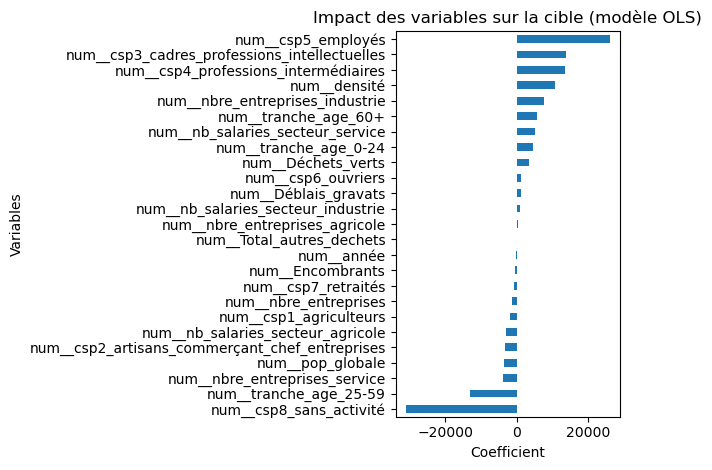

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
coefs_filtered.sort_values(by='Coefficient', ascending=True).plot.barh(x='Variable', y='Coefficient', legend=False)
plt.title("Impact des variables sur la cible (modèle OLS)")
plt.xlabel("Coefficient")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()
